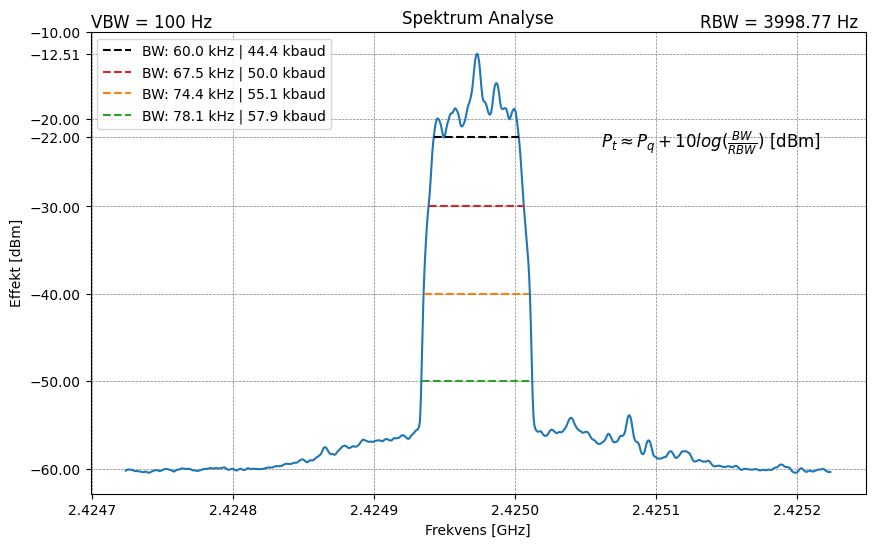

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

file_path="Måling/spektrum30dBAttenuator56kBaud035RollOff.csv"
columns = ['Power [dBm]', 'Frequency[Hz]']
spektrum = pd.read_csv(file_path, sep=',', names=columns, skiprows=154)
spektrum['Frequency[GHz]'] = spektrum['Frequency[Hz]'] / 1e9
spektrum['Power [dBm]'] = spektrum['Power [dBm]'] + 30 # Fjerne attenuatorens effekt

RBW= 3998.7715295257381 # Resolution Bandwidth in Hz
VBW = 100 # Video Bandwidth in Hz

# Calculate the bandwidth based on the thresholds
bw_thresholds = [-22,-30,-40,-50]
first_indecies = []
last_indecies = []

for bw_threshold in bw_thresholds:
    # Find first and last index where power is above bw_power
    first_index = spektrum[spektrum['Power [dBm]'] >= bw_threshold].index[0]
    last_index = spektrum[spektrum['Power [dBm]'] >= bw_threshold].index[-1]
    first_indecies.append(first_index)
    last_indecies.append(last_index)

# Calculate the bandwidths in kHz and baud rates
roll_off = 0.35 # Roll-off factor for the raised cosine filter
bandwidths = []
baud_rates = []
for first_index, last_index in zip(first_indecies, last_indecies):
    bandwidth = spektrum['Frequency[Hz]'][last_index] - spektrum['Frequency[Hz]'][first_index]
    bandwidths.append(bandwidth / 1000) # Convert to kHz
    baud_rates.append(bandwidth / (1 + roll_off) / 1000) # Assuming baud rate is half the bandwidth



bw_colors = ['k','tab:red', 'tab:orange', 'tab:green']
plt.figure(figsize=(10, 6))
plt.plot(spektrum['Frequency[GHz]'], spektrum['Power [dBm]'], linestyle='-', color='tab:blue')

for i, (first_index, last_index,bw_threshold,bandwidth, baud_rate) in enumerate(zip(first_indecies, last_indecies,bw_thresholds,bandwidths,baud_rates)):
    plt.plot([spektrum['Frequency[GHz]'][first_index], spektrum['Frequency[GHz]'][last_index]],
             [bw_threshold, bw_threshold], linestyle='--', color=bw_colors[i], label=f'BW: {bandwidth:.1f} kHz | {baud_rate:.1f} kbaud')
plt.legend(loc='upper left')

plt.annotate('RBW = {:.2f} Hz'.format(RBW), xy=(0.99, 1.01), xycoords='axes fraction', fontsize=12, ha='right')
plt.annotate('VBW = {} Hz'.format(VBW), xy=(0, 1.01), xycoords='axes fraction', fontsize=12, ha='left')
plt.grid(color='gray', linestyle='--', linewidth=0.5)

yticks = np.array([max(spektrum['Power [dBm]']),-22])
plt.yticks(np.append(np.arange(-60, 0, 10), yticks), fontsize=10)
plt.xlabel('Frekvens [GHz]')
plt.ylabel('Effekt [dBm]')
plt.title('Spektrum Analyse')
plt.show()

📡 -10 dB Båndbredde: 74.38 kHz
🚀 Estimert Baudrate: 55.09 kBaud
🔋 Total utgangseffekt: 29.89 dBm


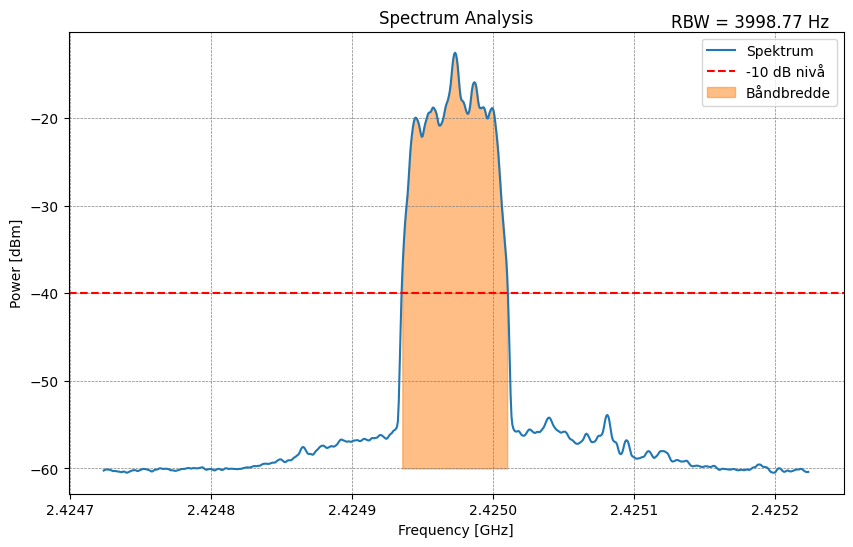

In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Last inn spektraldata
file_path = "Måling/spektrum30dBAttenuator56kBaud035RollOff.csv"
columns = ['Power [dBm]', 'Frequency[Hz]']
spektrum = pd.read_csv(file_path, sep=',', names=columns, skiprows=154)

# Juster for attenuator
spektrum['Power [dBm]'] += 30  

# Konverter frekvens til GHz
spektrum['Frequency[GHz]'] = spektrum['Frequency[Hz]'] / 1e9

# Frekvensoppløsning mellom datapunkter
delta_f = np.mean(np.diff(spektrum['Frequency[Hz]']))

# --- 1️⃣ Less av -10 dB båndbredden ---
bw_threshold = -40 

# Finn frekvenser hvor signalet er over -3 dB fra maks
bw_indices = spektrum[spektrum['Power [dBm]'] >= bw_threshold].index
bw_start = spektrum['Frequency[Hz]'][bw_indices[0]]
bw_stop = spektrum['Frequency[Hz]'][bw_indices[-1]]
bandwidth_kHz = (bw_stop - bw_start) / 1e3  # Til kHz

# --- 2️⃣ Estimer baudrate ---
roll_off = 0.35  # SRRC filter
baud_rate = bandwidth_kHz / (1 + roll_off)  # kBaud

# --- 3️⃣ Integrer spektrum for å finne total effekt ---
P_total_mW = np.sum(10 ** (spektrum['Power [dBm]'] / 10) * delta_f)
P_total_dBm = 10 * np.log10(P_total_mW)

# --- 📢 Utskrift av resultater ---
print(f"📡 -10 dB Båndbredde: {bandwidth_kHz:.2f} kHz")
print(f"🚀 Estimert Baudrate: {baud_rate:.2f} kBaud")
print(f"🔋 Total utgangseffekt: {P_total_dBm:.2f} dBm")

# --- 📊 Plot spektrumanalyse ---
plt.figure(figsize=(10, 6))
plt.plot(spektrum['Frequency[GHz]'], spektrum['Power [dBm]'], linestyle='-', color='tab:blue', label="Spektrum")
plt.axhline(y=bw_threshold, color='r', linestyle='--', label="-10 dB nivå")
plt.fill_between(spektrum['Frequency[GHz]'], spektrum['Power [dBm]'], -60, where=(spektrum.index >= bw_indices[0]) & (spektrum.index <= bw_indices[-1]), color='tab:orange', alpha=0.5, label="Båndbredde")
plt.annotate(f'RBW = {RBW:.2f} Hz', xy=(0.88, 1.01), xycoords='axes fraction', fontsize=12, ha='center')
plt.xlabel('Frequency [GHz]')
plt.ylabel('Power [dBm]')
plt.title('Spectrum Analysis')
plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.show()
